# Butterfly segmentation

In [1]:
from pathlib import Path
import json
from collections import defaultdict
from tqdm import tqdm
from ultralytics import YOLO
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from itertools import chain
import random
import math
os.chdir("/Users/idir/Desktop/Python/Butterfly/big_test")

## Convert COCO JSON to YOLO format

In [10]:
json_file = "/Users/idir/Downloads/Butterfly_roboflow_500/valid/_annotations.coco.json"

with open(json_file) as f:
    data_RR = json.load(f)

# Create image dict
images = {f'{x["id"]:d}': x for x in data_RR['images']}
# Create image-annotations dict
imgToAnns = defaultdict(list)
for ann in data_RR['annotations']:
    imgToAnns[ann['image_id']].append(ann)
        
bboxes = []
segments = []
image_name = []
# Write labels file
for img_id, anns in tqdm(imgToAnns.items(), desc=f'Annotations {json_file}'):
    img = images[f'{img_id:d}']
    h, w, f = img['height'], img['width'], img['file_name']

    for ann in anns:
        if ann['iscrowd']:
            continue
        # The COCO box format is [top left x, top left y, width, height]
        box = np.array(ann['bbox'], dtype=np.float64)
        box[:2] += box[2:] / 2  # xy top-left corner to center
        box[[0, 2]] /= w  # normalize x
        box[[1, 3]] /= h  # normalize y
        if box[2] <= 0 or box[3] <= 0:  # if w <= 0 and h <= 0
            continue

        box = [0] + box.tolist()
        if box not in bboxes:
            bboxes.append(box)
        if ann.get('segmentation') is not None:
            if len(ann['segmentation']) == 0:
                segments.append([])
                continue
            if isinstance(ann['segmentation'], dict):
                ann['segmentation'] = rle2polygon(ann['segmentation'])
            if len(ann['segmentation']) > 1:
                s = merge_multi_segment(ann['segmentation'])
                s = (np.concatenate(s, axis=0) / np.array([w, h])).reshape(-1).tolist()
            else:
                s = [j for i in ann['segmentation'] for j in i]  # all segments concatenated
                s = (np.array(s).reshape(-1, 2) / np.array([w, h])).reshape(-1).tolist()
            s = [0] + s
            if s not in segments:
                segments.append(s)
            image_name.append(f)

Annotations /Users/idir/Downloads/Butterfly_roboflow_500/valid/_annotations.coco


In [12]:
import os
import shutil

# Chemin vers le dossier source contenant les images
source_folder = '/Users/idir/Downloads/Butterfly_roboflow_500/valid/'

# Chemin vers le dossier de destination où vous souhaitez copier les images
destination_folder = '/Users/idir/Desktop/Python/Butterfly/big_test/images/val/'

#image_name_txt = [x.replace(".jpg",".txt") for x in os.listdir("/Users/idir/Downloads/Butterfly_roboflow/train/")]

# Boucle pour copier chaque image
for filename in tqdm(image_name):
    source_path = os.path.join(source_folder, filename)
    destination_path = os.path.join(destination_folder, filename)
    shutil.copyfile(source_path, destination_path)

100%|██████████████████████████████████████████| 71/71 [00:00<00:00, 247.54it/s]


In [13]:
# Dossier où vous voulez enregistrer les fichiers
output_folder = "/Users/idir/Desktop/Python/Butterfly/big_test/labels/val"
# Parcourir chaque sous-liste et écrire un fichier pour chacune
for (i,j) in zip(segments,image_name):
    # Générer un nom de fichier unique pour chaque sous-liste
    output_filename = os.path.join(output_folder, f'{j.split(".jpg")[0]}.txt')

    # Concaténer les éléments de la sous-liste en une chaîne de caractères
    content = ' '.join(map(str, i))

    # Écrire le contenu dans le fichier
    with open(output_filename, 'w') as file:
        file.write(content)


## Training

In [ ]:
model = YOLO('yolov8n-pose.pt') # pre-trained model weights
results = model.train(data='/Users/idir/Desktop/Python/Butterfly/big_test/big_test.yaml', epochs=400, imgsz=224)

## Prediction

In [3]:
model = YOLO('butterfly_seg.pt')

In [4]:
img_train = sorted(os.listdir("/Users/idir/Desktop/Python/Butterfly/big_test/images/train/"))
img_train = img_train[2:]
img_train = [x.split("_jpg")[0]+".jpg" for x in img_train]
img_train = sorted(list(set(img_train)))

img_val = sorted(os.listdir("/Users/idir/Desktop/Python/Butterfly/big_test/images/val/"))
img_val = img_val[2:]
img_val = [x.split("_jpg")[0]+".jpg" for x in img_val]
img_val = sorted(list(set(img_val)))

img_for_learning = img_train + img_val

random_imgs = sorted(os.listdir("/Users/idir/Desktop/Python/Butterfly/train/"))[1:]

random_img_fin = [x for x in random_imgs if x not in img_for_learning]
random_img_fin = ["/Users/idir/Desktop/Python/Butterfly/train/"+x for x in random_img_fin]

In [5]:
def select_random_elements(input_list, num_elements):
    if num_elements > len(input_list) or num_elements == 0:
        raise ValueError("Le nombre d'éléments à sélectionner est supérieur à la taille de la liste d'entrée ou est égal à 0.")
    
    return random.sample(input_list, num_elements)

In [8]:
imgs_to_predict = select_random_elements(random_img_fin, 10)
imgs_to_predict

['/Users/idir/Desktop/Python/Butterfly/train/Image_4018.jpg',
 '/Users/idir/Desktop/Python/Butterfly/train/Image_1657.jpg',
 '/Users/idir/Desktop/Python/Butterfly/train/Image_5970.jpg',
 '/Users/idir/Desktop/Python/Butterfly/train/Image_3587.jpg',
 '/Users/idir/Desktop/Python/Butterfly/train/Image_5350.jpg',
 '/Users/idir/Desktop/Python/Butterfly/train/Image_5468.jpg',
 '/Users/idir/Desktop/Python/Butterfly/train/Image_2612.jpg',
 '/Users/idir/Desktop/Python/Butterfly/train/Image_3443.jpg',
 '/Users/idir/Desktop/Python/Butterfly/train/Image_4190.jpg',
 '/Users/idir/Desktop/Python/Butterfly/train/Image_1523.jpg']

In [9]:
results = model.predict(imgs_to_predict,
                        imgsz=224
                       )


0: 224x224 1 butterfly, 1: 224x224 1 butterfly, 2: 224x224 1 butterfly, 3: 224x224 1 butterfly, 4: 224x224 1 butterfly, 5: 224x224 1 butterfly, 6: 224x224 1 butterfly, 7: 224x224 1 butterfly, 8: 224x224 1 butterfly, 9: 224x224 1 butterfly, 516.2ms
Speed: 3.0ms preprocess, 51.6ms inference, 5.0ms postprocess per image at shape (1, 3, 224, 224)


In [10]:
img_names = [x.split("/")[-1] for x in imgs_to_predict]

In [11]:
mask_images = []
for i in range(len(imgs_to_predict)):
    
    image_shape = (224, 224, 3)
    image = np.zeros(image_shape, dtype=np.uint8)
    
    mask_coordinates = results[i].masks.xy[0].tolist()
    mask_coordinates = np.array(mask_coordinates, dtype=np.int32)
    mask = np.zeros_like(image)
    mask_color = (255, 0, 255)

    cv2.fillPoly(mask, [mask_coordinates], mask_color)

    img_fin = cv2.add(image, mask)
    mask_images.append(img_fin)
    
ori_images = []
for i in imgs_to_predict:
    
    img_fin = cv2.cvtColor(cv2.imread(i),cv2.COLOR_BGR2RGB)
    
    ori_images.append(img_fin)

In [12]:
images = list(chain.from_iterable(zip(ori_images, mask_images)))
mask_title = ['Mask prediction']*len(imgs_to_predict)
titles = list(chain.from_iterable(zip(img_names, mask_title)))

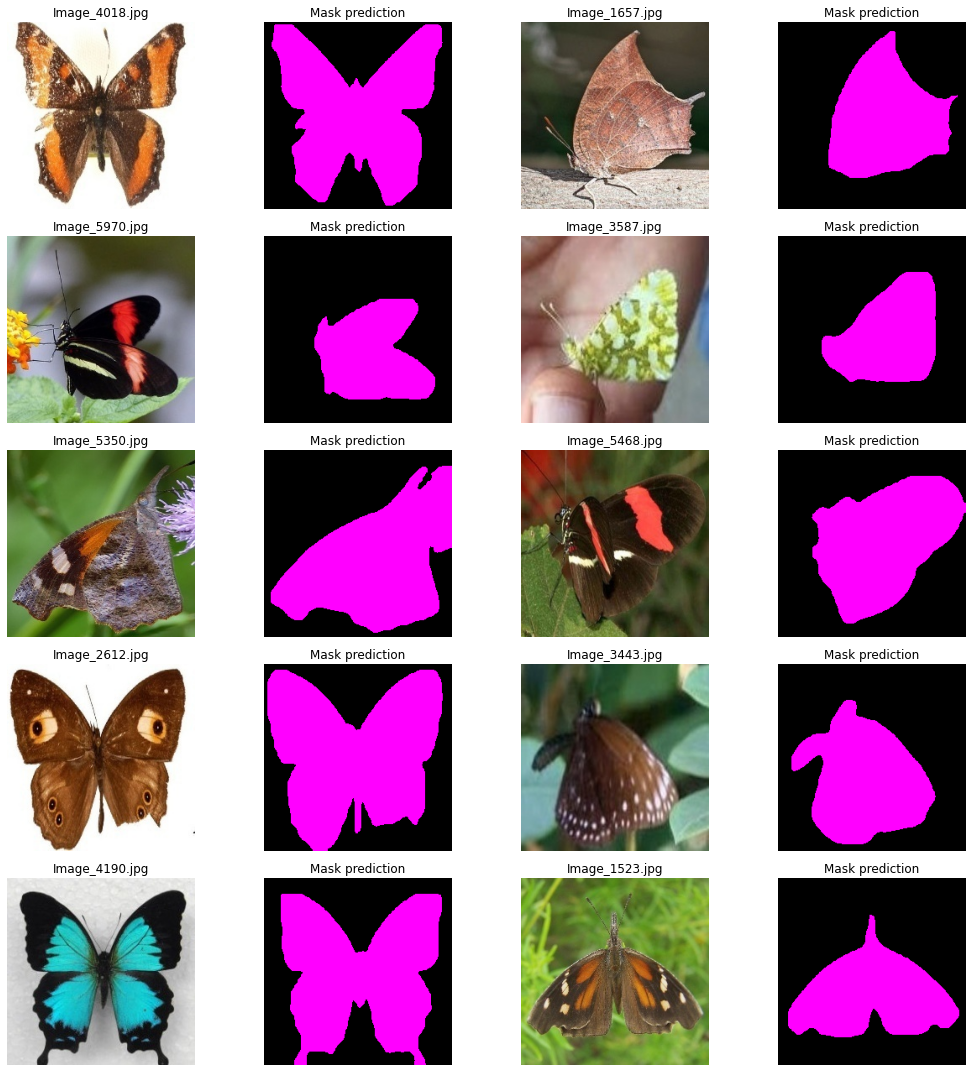

In [13]:
if len(imgs_to_predict) % 2 == 0:
    nrow = int(len(imgs_to_predict) / 2)
    ncol = 4
elif len(imgs_to_predict) == 1:
    nrow = 1
    ncol = 2
else:
    nrow = int(math.ceil(len(imgs_to_predict) / 2))
    ncol = 4
    

fig, axs = plt.subplots(nrow, ncol, figsize=(15,15))

for ax, img, title in zip(axs.flatten(), images, titles):
    ax.imshow(img, cmap='gray')
    ax.set_title(title)
    ax.axis('off')
    
if len(imgs_to_predict) % 2 == 1 and len(imgs_to_predict) != 1:
    axs[-1, -1].axis('off')
    axs[-1, -2].axis('off')

plt.tight_layout()
plt.show()